# Parking lots of L.A.

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
plt.rcParams['figure.figsize'] = (25,15)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

## Read/plot boundary files

### City of LA

In [2]:
cityboundary = gpd.read_file('input/la-city-boundary.geojson')

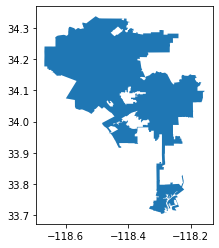

In [3]:
cityboundary.plot()

---

### LA County fire district

In [4]:
fireboundary = gpd.read_file('input/la-county-fire-district-boundary-4326.geojson')

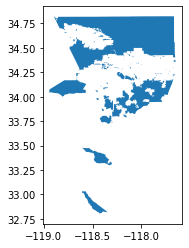

In [5]:
fireboundary.plot()

---

### LA Times neighborhoods in LA County

In [6]:
countyhoods = gpd.read_file('input/la-county-city-neighborhoods.geojson')

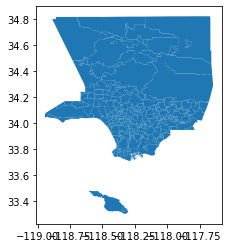

In [7]:
countyhoods.plot()

In [8]:
countyhoods['type'].value_counts()

segment-of-a-city      114
standalone-city         87
unincorporated-area     71
Name: type, dtype: int64

In [9]:
countyhoods.sqmi = countyhoods.sqmi.astype(float).round(6)

In [10]:
countyhoods_slim = countyhoods[['slug','name','type','sqmi','geometry']]

In [11]:
countyhoods_slim.head(2)

,slug,name,type,sqmi,geometry
0,acton,Acton,unincorporated-area,39.34,(POLYGON ((-118.2026174792054 34.5389897207692...
1,adams-normandie,Adams-Normandie,segment-of-a-city,0.81,(POLYGON ((-118.3090080000001 34.0374109991240...


In [12]:
lacityhoods = countyhoods[countyhoods['type'] == 'segment-of-a-city']

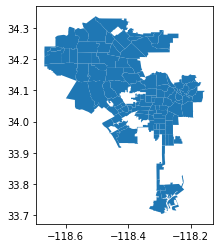

In [13]:
lacityhoods.plot()

---

### LA County industrial and commercial parking lots from tax assessor

In [14]:
### sliced from larger parcel file. need to explore other "parking lot" types, such as those at churces
parkinglots = gpd.read_file('input/parking-lot-parcels.geojson')

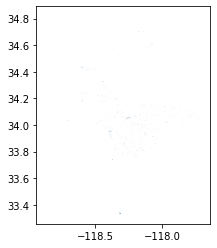

In [15]:
parkinglots.plot()

In [16]:
parkinglots.crs

{'init': 'epsg:4326'}

---

### Reproject parking lots to calculate area

In [17]:
parkinglots = parkinglots.to_crs({'init': "epsg:3311"})
parkinglots.crs

{'init': 'epsg:3311'}

### Calculate area of each parking lot in square feet

In [18]:
parkinglots['area_sq_ft'] = parkinglots.area * 10.764

### What's the area in square miles for all L.A. County parking lots?

In [19]:
parkinglots.area.sum() / 2.788e+7

0.8978033738948785

### How many parking lots? 

In [20]:
len(parkinglots)

14932

---

### Clean up the parcels/lots data for analysis

In [21]:
parkinglots = parkinglots.to_crs({'init': 'epsg:4326'})
# parkinglots = parkinglots.to_crs(epsg=4326)

In [22]:
parkinglots.crs

{'init': 'epsg:4326'}

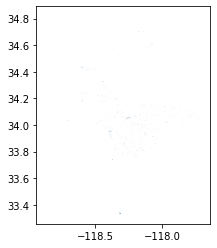

In [23]:
parkinglots.plot()

### Drop columns we don't need

In [24]:
lots = gpd.GeoDataFrame(parkinglots[['ogc_fid','ain','assr_map','situsaddress','situscity','situszip',\
                                 'designtype1','qualityclass1','yearbuilt1','effectiveyear1','recdate',\
                                 'lastsaleamount','lastsaledate','parcelcreatedate','taxratearea',\
                                 'usecode','usetype','roll_landvalue',\
                                 'roll_impvalue','roll_landbaseyear','roll_impbaseyear','ownername','ownerfullname',\
                                 'parceltypecode','roll_fixtureexemp',\
                                 'assr_index_map','geometry','area_sq_ft']])

In [25]:
# lots.to_crs({'init': "epsg:4326"})
# lots.crs = ({'init': "epsg:4326"})

In [26]:
lots.columns = lots.columns.str.replace('1','')

In [27]:
lots.dtypes

ogc_fid                int64
ain                   object
assr_map              object
situsaddress          object
situscity             object
situszip              object
designtype            object
qualityclass          object
yearbuilt             object
effectiveyear         object
recdate               object
lastsaleamount         int64
lastsaledate          object
parcelcreatedate       int64
taxratearea           object
usecode               object
usetype               object
roll_landvalue       float64
roll_impvalue        float64
roll_landbaseyear     object
roll_impbaseyear      object
ownername             object
ownerfullname         object
parceltypecode         int64
roll_fixtureexemp    float64
assr_index_map        object
geometry              object
area_sq_ft           float64
dtype: object

In [28]:
lots[['ogc_fid', 'parceltypecode', 'roll_fixtureexemp']] = \
lots[['ogc_fid', 'parceltypecode', 'roll_fixtureexemp']].astype(str)

### Parse dates

In [29]:
lots['parcelcreatedate'] = pd.to_datetime(lots['parcelcreatedate'].astype(str), format='%Y/%m/%d', errors='coerce')
lots['lastsaledate'] = pd.to_datetime(lots['lastsaledate'].astype(str), format='%Y/%m/%d', errors='coerce')
lots['recdate'] = pd.to_datetime(lots['recdate'].astype(str), format='%Y/%m/%d', errors='coerce')

In [30]:
lots.head()

,ogc_fid,ain,assr_map,situsaddress,situscity,situszip,designtype,qualityclass,yearbuilt,effectiveyear,recdate,lastsaleamount,lastsaledate,parcelcreatedate,taxratearea,usecode,usetype,roll_landvalue,roll_impvalue,roll_landbaseyear,roll_impbaseyear,ownername,ownerfullname,parceltypecode,roll_fixtureexemp,assr_index_map,geometry,area_sq_ft
0,788212,6053003010,6053-003,9305 S BROADWAY,LOS ANGELES CA,90003-4043,2700,DX,1957,1957,2005-11-23,700007,2005-11-23,NaT,08835,2700,Commercial,"196,006.00",0.00,2006,2006,"KIM,JEAN E","KIM,JEAN E",0,0.0,6053-NDX,"POLYGON ((-118.278533916647 33.95174106922584,...","4,480.81"
1,788213,8307022103,8307-022,,,,None,None,None,None,1998-08-13,9,1994-06-01,2011-01-21,02382,2700,Commercial,"358,219.00",0.00,1999,1999,CLAREMONT TENNIS CLUB,CLAREMONT TENNIS CLUB,0,0.0,8307-NDX,POLYGON ((-117.6985870149433 34.11424520676223...,"41,343.99"
2,788440,7319003107,7319-003,,,,None,None,None,None,2015-06-03,68359183,2015-06-03,2002-01-02,14989,3800,Industrial,"323,216.00","10,773.00",2015,2015,PROLOGIS USLV NEWCA 1 LLC,PROLOGIS USLV NEWCA 1 LLC C/O PROLOGIS - RE TAX,0,0.0,7319-NDX,POLYGON ((-118.2464974176995 33.86948399556537...,"18,342.59"
3,788465,6021014004,6021-014,7508 COMPTON AVE,FLORENCE CA,90001-2627,2700,DX,0000,0000,2007-05-21,0,2000-12-21,NaT,01198,2700,Commercial,"39,164.00","1,342.00",2001,2001,"VARGAS,LAZARO M TR","VARGAS,LAZARO M TR LAZARO M VARGAS TRUST",0,0.0,6021-NDX,POLYGON ((-118.2471652911795 33.97209199529052...,"3,537.34"
4,788538,8367002013,8367-002,,,,2700,,1976,1976,2008-02-05,2000020,2000-09-29,NaT,13362,2700,Commercial,"781,853.00","1,171.00",2008,2008,CHRISTIAN HARVEST CHURCH,CHRISTIAN HARVEST CHURCH C/O SEH YUANN WU,0,0.0,8367-NDX,POLYGON ((-117.7404203366071 34.10701046585448...,"25,992.39"


---

### Look at the county's tax rate areas

In [90]:
tra = pd.read_csv('input/TRA 2019-2020.csv')

In [92]:
tra.columns = tra.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [94]:
tra['nu_area'] = tra['area'].astype(str).str.zfill(5)

In [95]:
tra.sort_values(by='area', ascending=True).head(10)

,fy,area,legend,rate,nu_area
0,2019/2020,1,GENERAL,1.00,00001
4680,2019/2020,1,OTHER SERVICES,0.18,00001
33696,2019/2020,2,GENERAL,1.00,00002
33697,2019/2020,2,OTHER SERVICES,0.18,00002
38322,2019/2020,3,GENERAL,1.00,00003
38323,2019/2020,3,OTHER SERVICES,0.18,00003
2393,2019/2020,4,UNIFIED SCHOOLS,0.13,00004
2391,2019/2020,4,GENERAL,1.00,00004
2390,2019/2020,4,COUNTY,0.00,00004
2389,2019/2020,4,COMMNTY COLLEGE,0.03,00004


In [96]:
myhouse = tra[tra['nu_area'] == '00067']

In [97]:
myhouse

,fy,area,legend,rate,nu_area
6434,2019/2020,67,CITY-LOS ANGELES,0.02,00067
6435,2019/2020,67,COMMNTY COLLEGE,0.03,00067
6436,2019/2020,67,COUNTY,0.00,00067
6437,2019/2020,67,GENERAL,1.00,00067
6438,2019/2020,67,METRO WATER DIST,0.00,00067
6439,2019/2020,67,UNIFIED SCHOOLS,0.13,00067


---

### Parking lots by LA Times neighborhood and the City of LA

In [37]:
hood_lots = gpd.sjoin(parkinglots, countyhoods_slim, op='within')

In [38]:
hood_lots.head()

,ogc_fid,ain,assr_map,ownername,owneroverflow,secondowner,objectid,situsdirection,situsunit,situsaddress,situscity,situszip,mailaddress,mailcity,mailzip,designtype1,qualityclass1,yearbuilt1,units1,bedrooms1,bathrooms1,sqftmain1,effectiveyear1,sqftmain2,sqftmain3,...,usetype,usedescription,roll_year,roll_landvalue,roll_impvalue,roll_landbaseyear,roll_impbaseyear,ownerfullname,parceltypecode,shape.starea(),roll_fixtureexemp,assr_index_map,center_lat,center_lon,center_x,center_y,lat_lon,legaldescription,geometry,area_sq_ft,index_right,slug,name,type,sqmi
0,788212,6053003010,6053-003,"KIM,JEAN E",,,371199,S,,9305 S BROADWAY,LOS ANGELES CA,90003-4043,21828 KRATZMEYER RD,BAKERSFIELD CA,93314-9482,2700,DX,1957,0.00,0.00,0.00,"4,400.00",1957,nan,nan,...,Commercial,Parking Lots (Commercial Use Properties),2019,"196,006.00",0.00,2006,2006,"KIM,JEAN E",0,"4,480.92",0.00,6053-NDX,33.95,-118.28,"6,477,141.87","1,804,954.82","33.951790, -118.278706",TRACT # 4715 LOT 87,"POLYGON ((-118.278533916647 33.95174106922584,...","4,480.81",30,broadway-manchester,Broadway-Manchester,segment-of-a-city,1.56
5,788786,6040012008,6040-012,HOWELL INVESTMENTS LP,,,371723,,,,,,PO BOX 3425,BEVERLY HILLS CA,90212-3425,2700,OX,1960,0.00,0.00,0.00,"3,920.00",1960,nan,nan,...,Commercial,Parking Lots (Commercial Use Properties),2019,"81,790.00","22,063.00",2003,2003,HOWELL INVESTMENTS LP,0,"3,920.60",0.00,6040-NDX,33.96,-118.27,"6,478,314.23","1,807,871.98","33.959815, -118.274867",GOODFELLOWS TRACT EX OF ST LOT 9 BLK A,"POLYGON ((-118.274813634938 33.95995466886318,...","3,920.52",30,broadway-manchester,Broadway-Manchester,segment-of-a-city,1.56
7,788955,6040012016,6040-012,AUTOZONE DEVELOPMENT CORP,,,371872,W,,155 W 86TH PL,LOS ANGELES CA,90003-3305,PO BOX 2198,MEMPHIS TN,38101-2198,2700,DX,1971,0.00,0.00,0.00,"4,320.00",1971,nan,nan,...,Commercial,Parking Lots (Commercial Use Properties),2019,"70,260.00","7,017.00",1999,1999,AUTOZONE DEVELOPMENT CORP JOHN P WEBER DEPT 8700,0,"4,320.00",0.00,6040-NDX,33.96,-118.28,"6,478,034.22","1,807,769.41","33.959531, -118.275789",GOODFELLOWS TRACT LOT 48 BLK A,"POLYGON ((-118.275736156824 33.9596844829286, ...","4,319.91",30,broadway-manchester,Broadway-Manchester,segment-of-a-city,1.56
10,789327,6040013033,6040-013,PGB HOLDINGS LLC,,,372024,W,,222 W MANCHESTER AVE,LOS ANGELES CA,90003-3326,12910 MULBERRY DR,WHITTIER CA,90602-3455,2700,DX,1949,0.00,0.00,0.00,"3,900.00",1949,nan,nan,...,Commercial,Parking Lots (Commercial Use Properties),2019,"204,000.00","5,100.00",2018,2018,PGB HOLDINGS LLC,0,"3,922.09",0.00,6040-NDX,33.96,-118.28,"6,477,714.22","1,807,872.96","33.959813, -118.276846",GOODFELLOWS TRACT EX OF ST LOT 24 BLK A,"POLYGON ((-118.2767922592369 33.9599528654354,...","3,922.01",30,broadway-manchester,Broadway-Manchester,segment-of-a-city,1.56
17,789693,6040015901,6040-015,L A CITY,,,372360,,,,,,,,000000000,None,None,None,nan,nan,nan,nan,None,nan,nan,...,Commercial,Parking Lots (Commercial Use Properties),None,nan,nan,0000,0000,L A CITY,0,"4,319.54",nan,6040-NDX,33.96,-118.28,"6,477,514.20","1,807,622.25","33.959123, -118.277503",*TR=GOODFELLOWS TR LOT 29 BLK B,POLYGON ((-118.2774496489285 33.95927612470145...,"4,319.45",30,broadway-manchester,Broadway-Manchester,segment-of-a-city,1.56


In [39]:
hood_lots.to_file('output/hood_lots.geojson', driver='GeoJSON')

In [40]:
area_hoods = hood_lots.groupby(['slug']).agg({'area_sq_ft':'sum', 'sqmi':'mean'}).reset_index()

In [41]:
area_hoods['lots_area_sq_mile'] = area_hoods['area_sq_ft'] / 2.788e+7

In [42]:
area_hoods['lots_pct'] = (area_hoods['lots_area_sq_mile'] / area_hoods['sqmi']*100)

In [43]:
area_hoods.sort_values(by='lots_pct', ascending=False).head(20)

,slug,area_sq_ft,sqmi,lots_area_sq_mile,lots_pct
52,downtown,"13,633,169.08",5.84,0.49,8.38
89,hollywood,"4,734,259.47",3.51,0.17,4.84
221,westlake,"3,441,052.86",2.72,0.12,4.54
40,chinatown,"836,433.60",0.91,0.03,3.30
62,el-segundo,"4,242,653.84",5.46,0.15,2.79
98,koreatown,"2,014,038.19",2.70,0.07,2.68
205,vernon,"3,776,052.96",5.22,0.14,2.59
196,university-park,"822,817.54",1.17,0.03,2.53
149,playa-vista,"906,910.95",1.30,0.03,2.50
220,westchester,"7,449,697.58",10.81,0.27,2.47


In [44]:
area_hoods.to_csv('output/area_hoods.csv')

---

### Split the dataframe into neighborhood pieces and export them

In [45]:
hoodslist = area_hoods.slug.tolist()

In [46]:
for h in hoodslist:
    place = hood_lots[hood_lots['slug'] == h]
    place.to_file(f'output/places/' + h + '.geojson', driver='GeoJSON')